# Assignment 3

**Course:** Introdução ao Processamento Digital de Imagem (MO443)  
**Goal:** To study a few of the segmentation strategies available in order to correctly identify the multiple objects in images  
**Author:** Lucas Oliveira David, 188972 --- <lucas.david@ic.unicamp.br>

In [1]:
import seaborn as sns

class Config:
    class data:
        path = '/content/drive/MyDrive/datasets/MO443/simple-shapes'
        
    properties = ('label', 'area', 'convex_area', 'eccentricity', 'solidity', 'perimeter', 'centroid', 'bbox')
    colors = sns.color_palette("Set3")
    seed = 68215

## Setup

In [2]:
from math import ceil
from functools import partial as ftpartial

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import skimage.io
import skimage.filters
import skimage.feature
import skimage.segmentation
from skimage.measure import regionprops_table

from skimage.color import label2rgb

In [3]:
sns.set()

def partial(func, *args, **kwargs):
    partial_func = ftpartial(func, *args, **kwargs)
    partial_func.__name__ = (f"{func.__name__} {' '.join(map(str, args))}"
                             f" {' '.join((f'{a}={b}' for a, b in kwargs.items()))}")
    return partial_func

def visualize(
    image,
    title=None,
    rows=2,
    cols=None,
    cmap=None,
    figsize=(12, 6)
):
    if image is not None:
        if isinstance(image, list) or len(image.shape) > 3:  # many images
            fig = plt.figure(figsize=figsize)
            cols = cols or ceil(len(image) / rows)
            for ix in range(len(image)):
                plt.subplot(rows, cols, ix+1)
                visualize(image[ix],
                          cmap=cmap,
                          title=title[ix] if title is not None and len(title) > ix else None)
            plt.tight_layout()
            return fig

        if image.shape[-1] == 1: image = image[..., 0]
        plt.imshow(image, cmap=cmap)
    
    if title is not None: plt.title(title)
    plt.axis('off')

def plot_segments(g, s, p, alpha=0.8, ax=None, linewidth=1):
    ax = ax or plt.gca()
    ax.imshow(label2rgb(s, image=g, bg_label=0, alpha=alpha, colors=Config.colors, bg_color=(1,1,1)))
    ax.axis('off')

    for i, region in p.iterrows():
        minr, minc, maxr, maxc = region['bbox-0'], region['bbox-1'], region['bbox-2'],region['bbox-3']
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False,
                             edgecolor=Config.colors[i % len(Config.colors)], linewidth=linewidth)
        ax.add_patch(rect)

        plt.text(region['centroid-1'], region['centroid-0'], int(region.label))

def plot_detection_boxes(p, ax=None, linewidth=1):
    if ax is None:
        ax = plt.gca()

    H, W, C = p['image'].shape
    bboxes = p['objects']['bbox'].numpy()
    labels = p['objects']['label'].numpy()
    
    for b, l in zip(bboxes, labels):
        minr, minc, maxr, maxc = b
        minr, minc, maxr, maxc = minr*H, minc*W, maxr*H, maxc*W
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False,
                             edgecolor=Config.colors[l % len(Config.colors)], linewidth=linewidth)
        ax.add_patch(rect)
        ax.text(minc,minr, int2str(l))

## Datasets

### Simple Shapes

In [4]:
image_files = sorted(os.listdir(Config.data.path))
images = [skimage.io.imread(os.path.join(Config.data.path, f)) for f in image_files]
grays = [skimage.color.rgb2gray(i) for i in images]

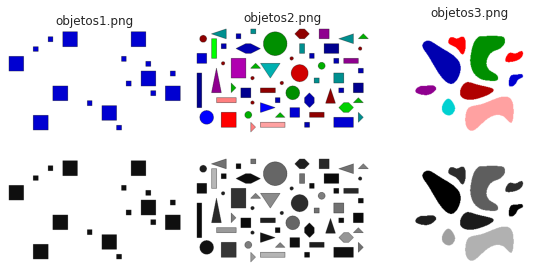

In [5]:
#@title

visualize([*images, *grays], image_files, cmap='gray', figsize=(8, 4));

### BCCD

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds

(train,), info = tfds.load('bccd', split=['train'], with_info=True, shuffle_files=False)

int2str = info.features['objects']['label'].int2str

bccd_samples = list(train.take(10))
bccd_images = [s['image'].numpy() for s in bccd_samples]
bccd_grays = [skimage.color.rgb2gray(i) for i in bccd_images]

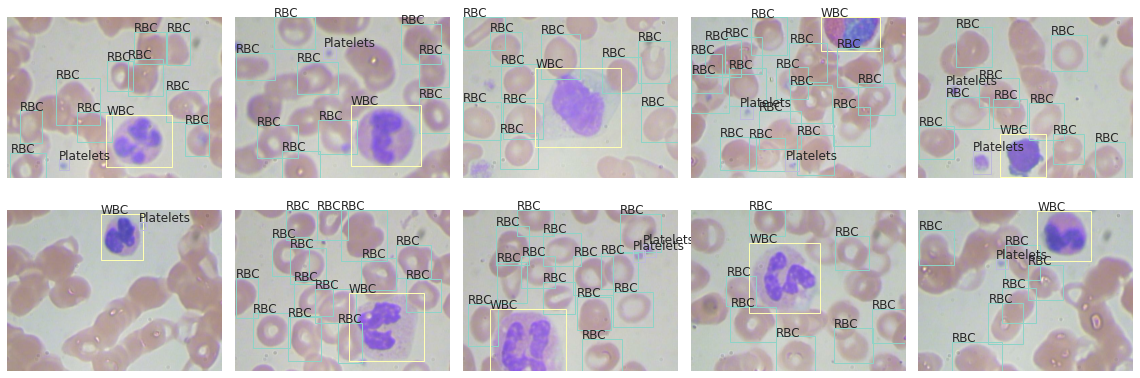

In [7]:
#@title

fig = visualize([s['image'] for s in bccd_samples], rows=2, figsize=(16, 6))
axes = fig.get_axes()

for ax, p in zip(axes, bccd_samples):
    plot_detection_boxes(p, ax)

## Object Boundaries

In [8]:
%%time

N = 3

methods = [
  skimage.filters.sobel,
  skimage.filters.roberts,
  skimage.filters.prewitt,
  skimage.filters.farid,
  skimage.filters.scharr,
  partial(skimage.feature.canny, sigma=0.),
  partial(skimage.feature.canny, sigma=0.1),
  partial(skimage.feature.canny, sigma=3.),
]

visualizing = grays + bccd_grays[:N]
segments = [[m(g) for g in visualizing]
            for m in methods]

CPU times: user 1.52 s, sys: 75.4 ms, total: 1.6 s
Wall time: 1.65 s


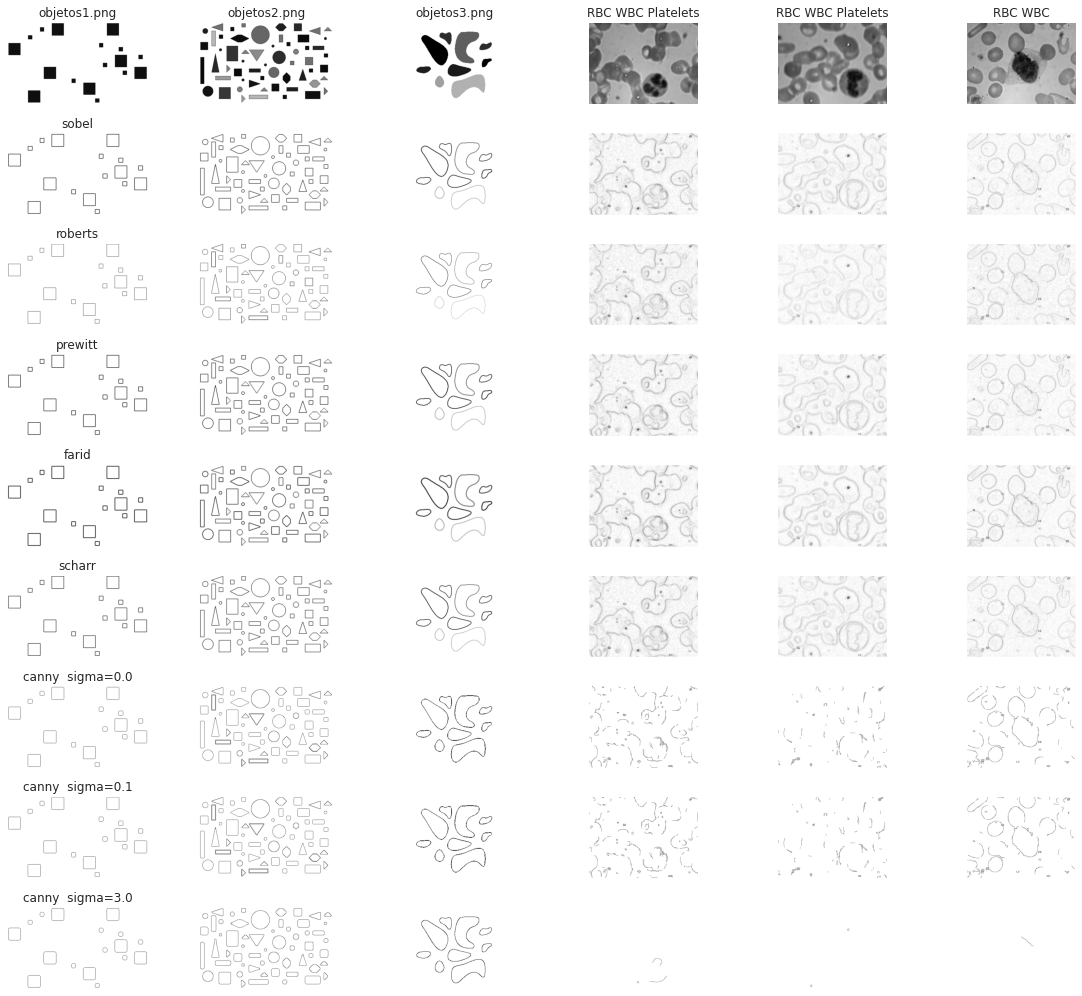

In [9]:
#@title

image_names = image_files + [' '.join(map(int2str, np.unique(s['objects']['label']))) for s in bccd_samples[:N]]

method_names = [n.__name__ for n in methods]
method_names = sum([[e]+[None]*(len(visualizing)-1) for e in method_names], [])

visualize(
  visualizing + [1-e for e in sum(segments, [])],
  image_names + method_names,
  rows=1 + len(methods),
  cmap='gray',
  figsize=(16, 14));

## Segmentation using Felzenszwalb

#### Region Properties of Simple Shapes

In [10]:
def print_properties_report(ps, name=None, detail=None):
    if name: print(name)
        
    print('número de regiões:', len(ps))
    print('número de regiões pequenas:', (ps.area < 1500).sum())
    print('número de regiões grandes:', ((ps.area >= 1500) & (ps.area < 3000)).sum())
    print('número de regiões grandes:', (ps.area >= 3000).sum())
    print()

    if detail:
      ps = ps.head(detail)

    for ix, p in ps.iterrows():
        print(f'região {p.label:6.0f}: área: {int(p.area):6d} perímetro: {p.perimeter:12.6f} '
              f'excentricidade: {p.eccentricity:.6f} solidez: {p.solidity:.6f}')
    
    print()

In [11]:
segments = [skimage.segmentation.felzenszwalb(g, scale=1e6, sigma=0.1, min_size=10) for g in grays]
props = [pd.DataFrame(regionprops_table(s, properties=Config.properties)) for s in segments]

In [12]:
for ix in range(len(props)):
  print_properties_report(props[ix], image_files[ix], detail=5)

objetos1.png
número de regiões: 17
número de regiões pequenas: 9
número de regiões grandes: 8
número de regiões grandes: 0

região      1: área:   2352 perímetro:   190.000000 excentricidade: 0.201039 solidez: 1.000000
região      2: área:   2352 perímetro:   190.000000 excentricidade: 0.201039 solidez: 1.000000
região      3: área:    272 perímetro:    62.000000 excentricidade: 0.338502 solidez: 1.000000
região      4: área:    272 perímetro:    62.000000 excentricidade: 0.338502 solidez: 1.000000
região      5: área:   2304 perímetro:   188.000000 excentricidade: 0.000000 solidez: 1.000000

objetos2.png
número de regiões: 58
número de regiões pequenas: 47
número de regiões grandes: 9
número de regiões grandes: 2

região      1: área:    816 perímetro:   138.012193 excentricidade: 0.816371 solidez: 0.964539
região      2: área:    272 perímetro:    62.000000 excentricidade: 0.338502 solidez: 1.000000
região      3: área:   1024 perímetro:   118.852814 excentricidade: 0.631713 solidez:

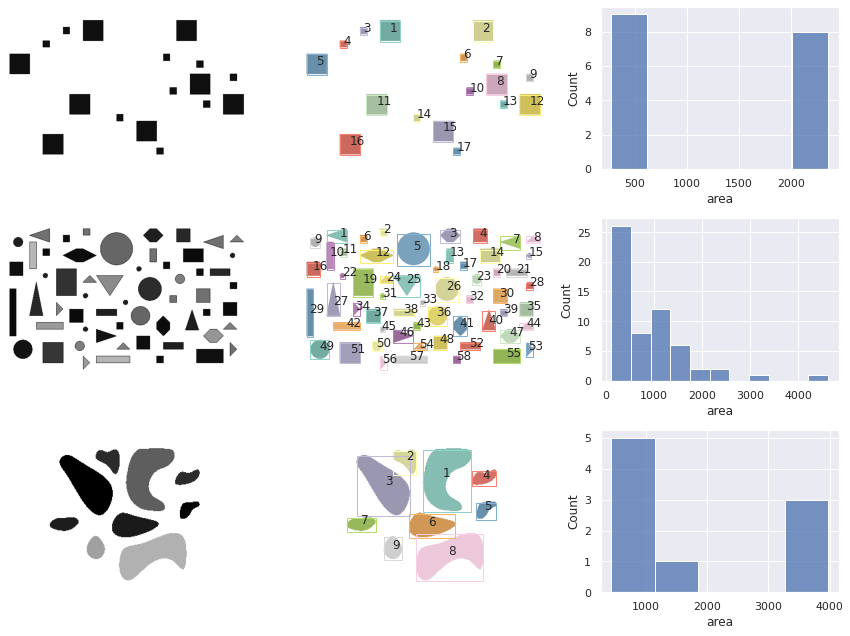

In [13]:
#@title

plt.figure(figsize=(12, 9))

N = len(props)

for ix, (image, label, prop) in enumerate(zip(grays, segments, props)):
  plt.subplot(N, 3, 3*ix+1)
  visualize(image, cmap='gray')

  # if bboxes is not None:
  #   plot_detection_boxes(bboxes)

  plt.subplot(N, 3, 3*ix+2)
  plot_segments(image, label, prop)

  plt.subplot(N, 3, 3*ix+3)
  sns.histplot(prop.area)

plt.tight_layout();

### Object Detection (BCCD)

In [14]:
images = [i['image'].numpy() for i in bccd_samples]
segments = [skimage.segmentation.felzenszwalb(i, scale=1e4, sigma=0.01, min_size=75) for i in images]

props = [pd.DataFrame(regionprops_table(s, properties=Config.properties)) for s in segments]

In [15]:
for ix in range(len(props)):
  print_properties_report(props[ix], f'sample {ix}', detail=5)

sample 0
número de regiões: 27
número de regiões pequenas: 20
número de regiões grandes: 2
número de regiões grandes: 5

região      1: área: 118323 perímetro:  5056.725322 excentricidade: 0.766929 solidez: 0.504214
região      2: área:   1121 perímetro:   197.947222 excentricidade: 0.954924 solidez: 0.712651
região      3: área:  38266 perímetro:  1511.518903 excentricidade: 0.380601 solidez: 0.690872
região      4: área:    358 perímetro:   132.698485 excentricidade: 0.972521 solidez: 0.697856
região      5: área:   1454 perímetro:   198.219300 excentricidade: 0.832212 solidez: 0.853286

sample 1
número de regiões: 38
número de regiões pequenas: 27
número de regiões grandes: 3
número de regiões grandes: 8

região      1: área:  16957 perímetro:   806.054870 excentricidade: 0.966490 solidez: 0.847596
região      2: área:   6354 perímetro:   992.120887 excentricidade: 0.765319 solidez: 0.335516
região      3: área:  29049 perímetro:  2517.379905 excentricidade: 0.903952 solidez: 0.7409

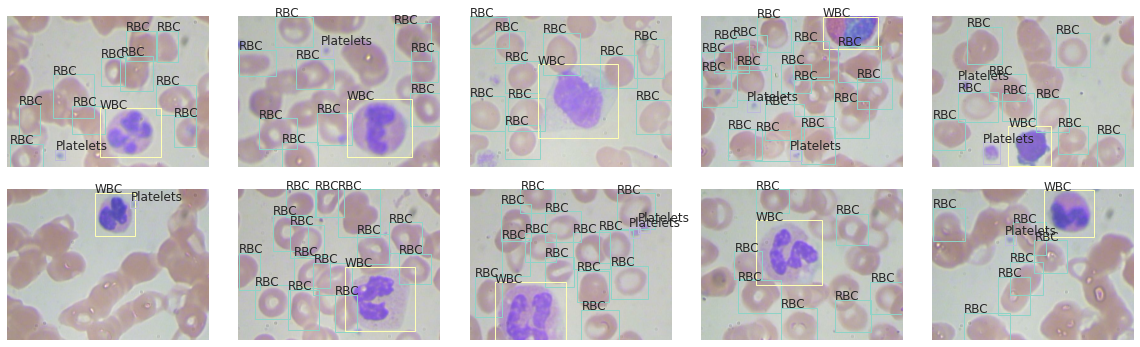

In [16]:
#@title

fig = visualize(images, figsize=(16, 5))
axes = fig.get_axes()

for ax, p in zip(axes, bccd_samples):
  plot_detection_boxes(p, ax)

plt.tight_layout();

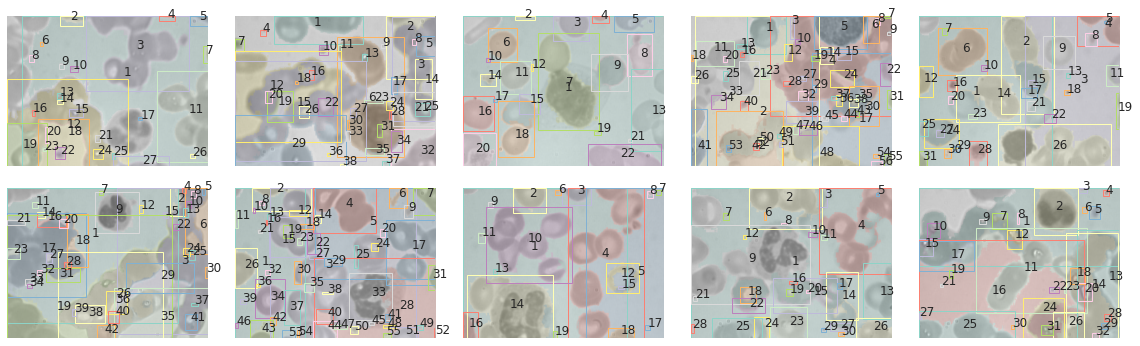

In [17]:
#@title

plt.figure(figsize=(16, 5))

for ix, (image, bboxes, label, prop) in enumerate(zip(images, bccd_samples, segments, props)):
  ax = plt.subplot(2, 5, ix+1)
  plot_segments(image, label, prop, alpha=0.2, ax=ax)

plt.tight_layout()

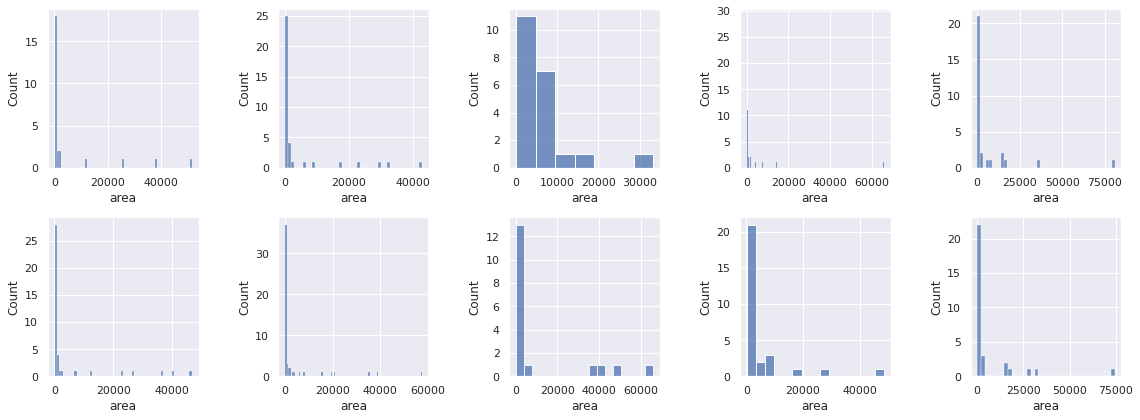

In [18]:
#@title

plt.figure(figsize=(16, 6))

for ix, prop in enumerate(props):
  plt.subplot(2, ceil(len(props)/2), ix +1)
  sns.histplot(prop.area[prop.area < np.percentile(prop.area, 99)])

plt.tight_layout();

## Morphological Boundaries

In [19]:
from skimage.measure import label
from skimage.filters import threshold_otsu
from skimage.morphology import opening, closing, square

def morphological_segmentation(image, so=square(5)):
  bw = image < threshold_otsu(image)

  return label(opening(closing(bw, so),  so))

In [20]:
%%time

segments = [morphological_segmentation(image) for image in bccd_grays]
props = [pd.DataFrame(regionprops_table(s, properties=Config.properties)) for s in segments]

CPU times: user 1.17 s, sys: 519 ms, total: 1.69 s
Wall time: 1.16 s


In [21]:
for ix in range(len(props)):
  print_properties_report(props[ix], f'sample {ix}', detail=5)

sample 0
número de regiões: 18
número de regiões pequenas: 12
número de regiões grandes: 0
número de regiões grandes: 6

região      1: área:  47958 perímetro:  2453.030663 excentricidade: 0.825240 solidez: 0.560978
região      2: área:   1147 perímetro:   190.426407 excentricidade: 0.978781 solidez: 0.931006
região      3: área:  30070 perímetro:  1401.276262 excentricidade: 0.493443 solidez: 0.641548
região      4: área:     85 perímetro:    47.656854 excentricidade: 0.978029 solidez: 0.923913
região      5: área:    587 perímetro:   112.284271 excentricidade: 0.895710 solidez: 0.970248

sample 1
número de regiões: 13
número de regiões pequenas: 4
número de regiões grandes: 0
número de regiões grandes: 9

região      1: área:   5681 perímetro:   497.705627 excentricidade: 0.556644 solidez: 0.774506
região      2: área:   7059 perímetro:   471.036580 excentricidade: 0.937312 solidez: 0.936704
região      3: área:  27916 perímetro:  1585.484415 excentricidade: 0.933720 solidez: 0.62742

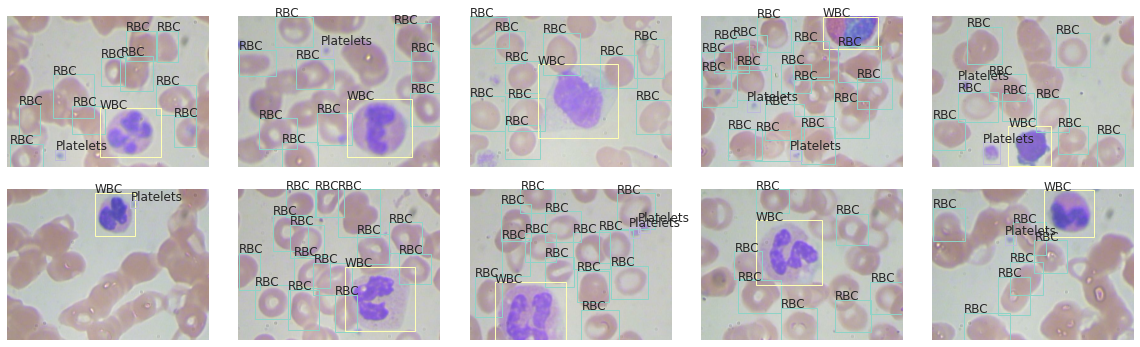

In [22]:
#@title

fig = visualize(images, figsize=(16, 5))
axes = fig.get_axes()

for ax, p in zip(axes, bccd_samples):
  plot_detection_boxes(p, ax)

plt.tight_layout();

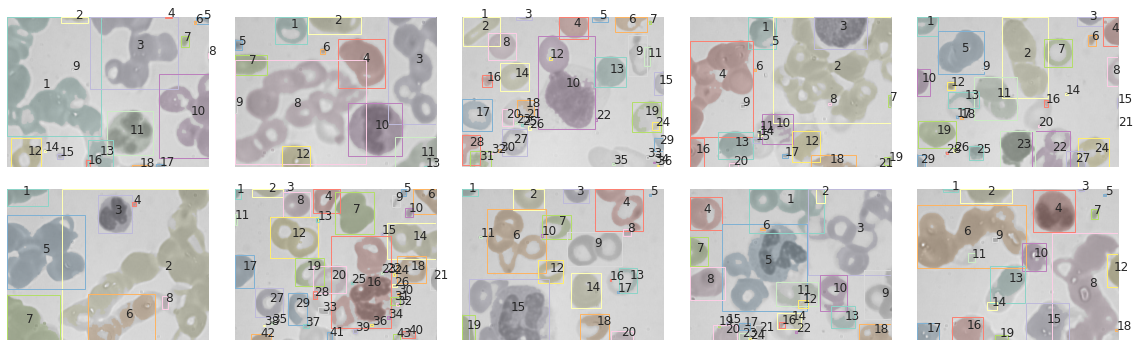

In [23]:
#@title

plt.figure(figsize=(16, 5))

for ix, (image, bboxes, label, prop) in enumerate(zip(images, bccd_samples, segments, props)):
  ax = plt.subplot(2, 5, ix+1)
  plot_segments(image, label, prop, alpha=0.2, ax=ax)

plt.tight_layout()

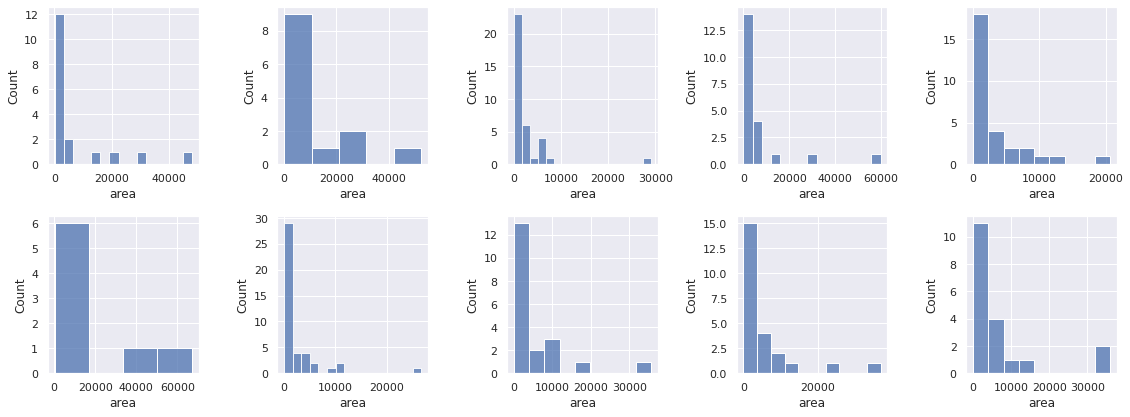

In [24]:
#@title

plt.figure(figsize=(16, 6))

for ix, prop in enumerate(props):
  plt.subplot(2, ceil(len(props)/2), ix +1)
  # sns.histplot(prop.area[prop.area < np.percentile(prop.area, 99)])
  sns.histplot(prop.area)

plt.tight_layout();